In [1]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [2]:
BASE_DIR = "./tests/underspecified"
PROFILE = "model"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile non-linear-1d-1k ======
Train: (-2, 2)
Y-space: -5.33279118005547 - 2.44630726320173
In Domain: (-2, 2)
Y-space: -5.34177646502616 - 2.5189897426265793
Out Domain: (-4, 4)
Y-space: -11.621171129536249 - 8.498793987886877


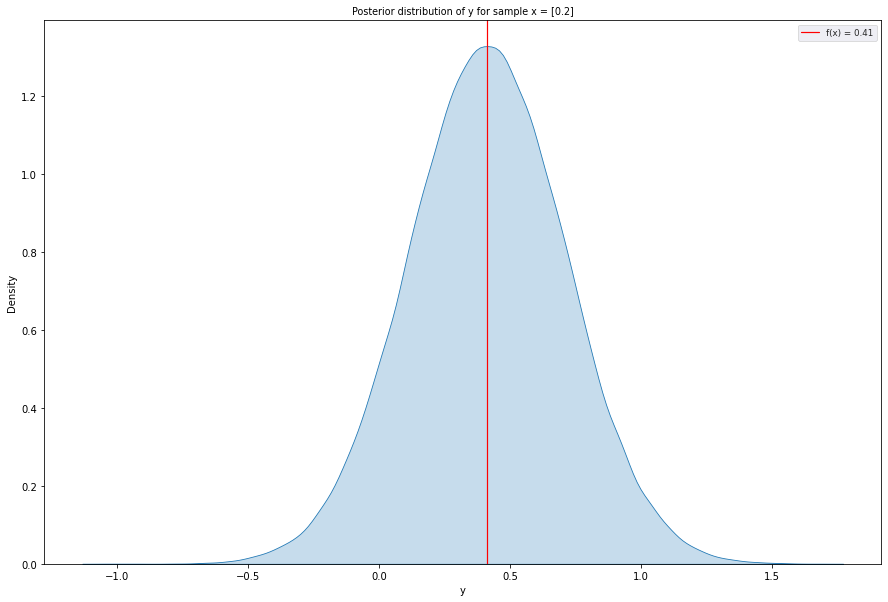

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


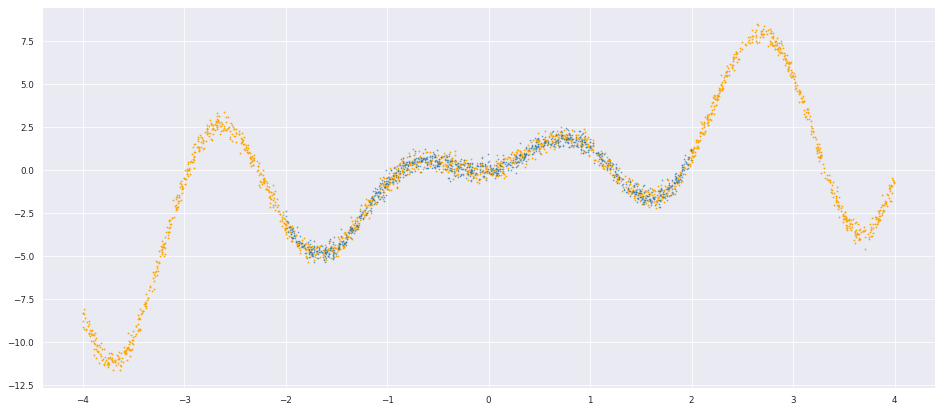

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=512)

In [9]:
"""MCMC learnable"""

'MCMC'

In [20]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.1))

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [21]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=100, warmup_steps=200)

Sample: 100%|██████████| 300/300 [08:42,  1.74s/it, step size=1.63e-03, acc. prob=0.861]


In [23]:
bnn._mcmc.summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
  likelihood._scale      0.29      0.01      0.29      0.28      0.30     48.58      0.99
      net.0.bias[0]     -2.41      0.76     -2.62     -3.38     -0.98      4.53      1.42
      net.0.bias[1]      0.57      0.87      0.58     -0.63      1.66      2.54      3.54
      net.0.bias[2]     -1.13      0.81     -1.27     -2.26      0.06      7.15      1.29
      net.0.bias[3]      0.07      0.37      0.08     -0.67      0.62     13.01      1.06
      net.0.bias[4]     -2.78      0.61     -2.78     -3.61     -1.68      7.62      1.35
      net.0.bias[5]     -0.41      1.06     -0.16     -2.15      0.95      5.52      1.46
      net.0.bias[6]     -1.17      0.28     -1.16     -1.57     -0.64     13.77      1.12
      net.0.bias[7]     -0.20      1.09     -0.64     -1.77      1.58      7.42      0.99
      net.0.bias[8]      0.05      0.58      0.06     -0.79      0.93      5.16      1.56
      net

In [24]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

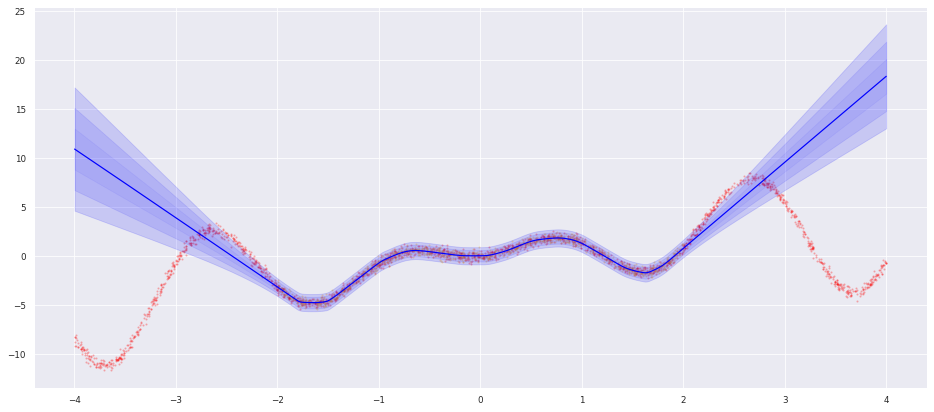

In [25]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=c/2 * 0.1, color="blue")

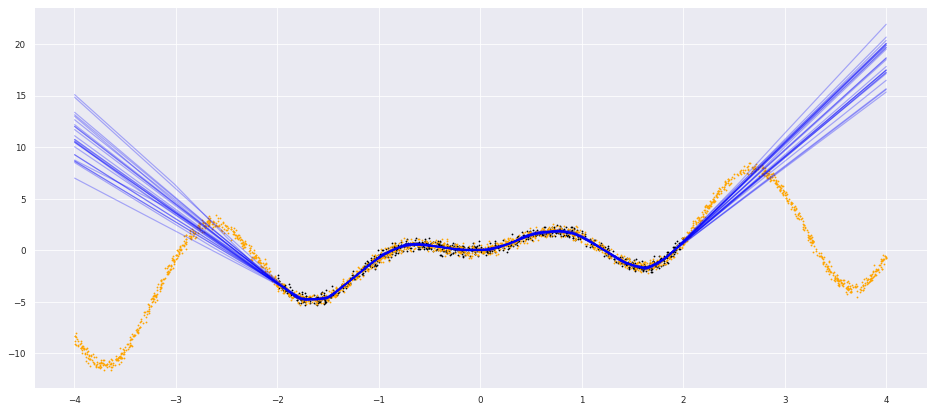

In [26]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [ ]:
"""MCMC fixed"""

In [41]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.2))

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [42]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=1000, warmup_steps=2000, num_chains=2)

Warmup [1]:   0%|          | 0/3000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/3000 [00:00, ?it/s]

In [43]:
with open(f"{BASE_DIR}/results/{NAME}/mcmc_diagnostics.json", "w") as f:
    json.dump(bnn._mcmc.diagnostics(), f)

{'likelihood._scale': OrderedDict([('n_eff', tensor(73.1617)),
              ('r_hat', tensor(1.0222))]),
 'net.0.bias': OrderedDict([('n_eff',
               tensor([28.1188, 19.9418, 21.0908,  9.0447,  8.9478, 19.4273, 30.5092, 24.2536,
                       42.1813, 14.9852, 30.4245, 20.8472, 14.9368, 21.8133, 55.9571, 25.3654,
                       35.4766, 23.2572, 22.4960, 20.9510, 15.1961, 27.7212, 26.9352, 19.7896,
                       41.7718, 16.8678,  7.3453, 14.0947, 39.6661, 17.7825, 29.9762, 26.4487])),
              ('r_hat',
               tensor([1.0902, 1.0260, 1.0987, 1.3838, 1.3473, 1.0380, 1.1193, 1.0455, 1.0317,
                       1.1172, 1.1554, 1.0771, 1.1363, 1.0555, 1.0035, 1.0197, 1.0388, 1.0500,
                       1.1028, 1.0346, 1.1709, 1.0513, 1.0506, 1.0618, 1.0444, 1.1356, 1.2968,
                       1.2298, 1.0243, 1.1919, 1.1271, 1.0358]))]),
 'net.0.weight': OrderedDict([('n_eff',
               tensor([[64.2430],
                      

In [44]:
bnn._mcmc.summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
  likelihood._scale      0.29      0.01      0.29      0.28      0.30     73.16      1.02
      net.0.bias[0]     -0.05      1.34      0.01     -2.49      1.99     28.12      1.09
      net.0.bias[1]     -0.45      1.57     -0.46     -2.94      2.03     19.94      1.03
      net.0.bias[2]     -1.10      1.55     -1.13     -3.50      1.22     21.09      1.10
      net.0.bias[3]     -1.05      1.59     -1.10     -3.55      1.36      9.04      1.38
      net.0.bias[4]     -0.57      1.69     -0.29     -3.20      1.88      8.95      1.35
      net.0.bias[5]     -0.33      1.51     -0.08     -3.03      1.71     19.43      1.04
      net.0.bias[6]     -0.59      1.20     -0.71     -2.65      1.39     30.51      1.12
      net.0.bias[7]      0.06      1.21      0.11     -1.74      2.32     24.25      1.05
      net.0.bias[8]      0.16      1.34      0.07     -1.82      2.48     42.18      1.03
      net

In [45]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

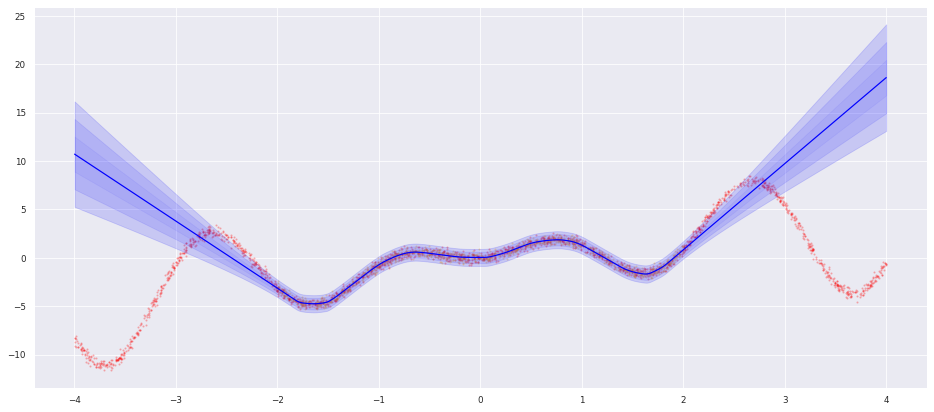

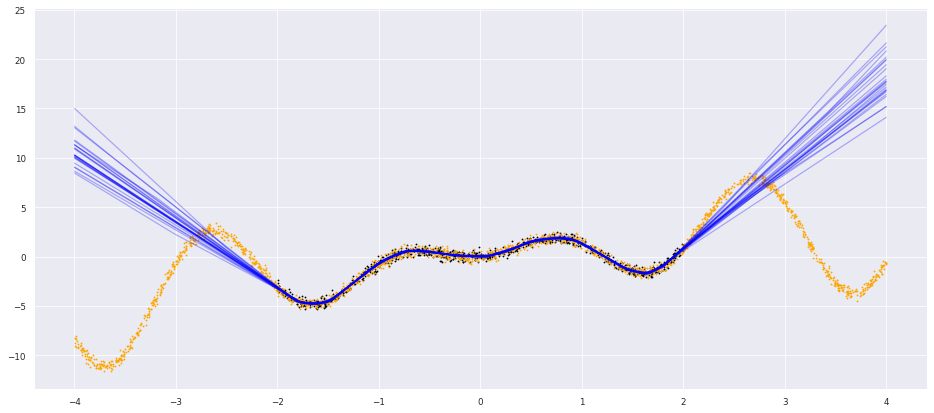

In [46]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=c/2 * 0.1, color="blue")

sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)